# Calculate nucleotide diversity (π)  for H5N1 within-host data

September 13, 2019 

We would like to generate estimates of gene-wise πN and πS values to test for selection across coding regions. Chase Nelson's program, SNPGenie (https://github.com/chasewnelson/snpgenie) was written to calculate diversity statistics (like π and divergence) on within-host viral data. It takes as input gtf files and vcf files and will output a series of statistics. This software package is nice because the vcf input allows the user to pre-filter variants before inclusion in the diversity estimation. As with all other analyses in this paper, I used SNVs called at a minimum frequency of 1%. Details for how π values are calculated are detailed on the SNPGenie github page (https://github.com/chasewnelson/snpgenie). 

The results from calculating πN and πS on the within-host data can be found in "data/pi-values.tsv". The code in this notebook is for reading this data in, bootstrapping the values, and plotting it to produce Figure 3. 

In [51]:
# import necessary modules
import sys, subprocess, glob, os, shutil, re, importlib, Bio, csv
from subprocess import call
from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy import stats


import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [52]:
# define colors 
human_color = "#C75643"
duck_color = "#545AB7"

duck_nonsyn_color = "#545AB7"
duck_syn_color = "#98B4DA"
human_nonsyn_color = "#C75643"
human_syn_color = "#E6B692"

## Read in pi data

In [70]:
"""read in the tsv file containing the pi results"""
df = pd.read_table("../data/pi-values.tsv", sep="\t")

# replace NA with neuram
df['product'] = df['product'].fillna('neuram')          

# add in a species column
df['species'] = np.where((df['file'].str.contains("duck")), "duck","human") 
df.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


,file,product,N_diffs,S_diffs,N_diffs_vs_ref,S_diffs_vs_ref,N_sites,S_sites,piN,piS,mean_dN_vs_ref,mean_dS_vs_ref,mean_gdiv_polymorphic,mean_N_gdiv,mean_S_gdiv,species
0,AA4KNL706F512_A_Cambodia_X0128304_2013,HA,1.767124,0.223554,0.873365,0.116171,1332.740397,370.650907,0.001326,0.000603,0.000655,0.000313,0.198084954560712,0.251180976713173,0.0741942362049676,human
1,AA4KNL706F512_A_Cambodia_X0128304_2013,M1,0.350853,0.208944,0.185506,0.110311,578.515594,177.484406,0.000606,0.001177,0.000321,0.000622,0.0929131325381493,0.0872814044904492,0.104176588633549,human
2,AA4KNL706F512_A_Cambodia_X0128304_2013,M2,0.095517,0.000000,0.050139,0.000000,227.000000,64.000000,0.000421,0.000000,0.000221,0.000000,0.095250657583352,0.095250657583352,*,human
3,AA4KNL706F512_A_Cambodia_X0128304_2013,neuram,0.137856,0.215735,0.071550,0.115099,1050.119423,296.880577,0.000131,0.000727,0.000068,0.000388,0.08812925082461,0.0687268855488714,0.107531616100349,human
4,AA4KNL706F512_A_Cambodia_X0128304_2013,NEP,0.058154,0.000000,0.029891,0.000000,286.009964,76.990036,0.000203,0.000000,0.000105,0.000000,0.0579956285444234,0.0579956285444234,*,human


## Generate a full genome diversity estimate for each sample 

Generate a full genome estimate by taking weighted average of all the genes together.

From the genome of A/Vietnam/12032/004 from this set of Genbank numbers (AY818144), these are the lengths of the genes in the genome, and their proportion of the genome: 

PB2: 2289 = 0.172

PB1: 2274 = 0.170

PA: 2151 = 0.161

HA: 1707 = 0.128

NP: 1507 = 0.113

NA: 1350 = 0.101

M1: 759 = 0.057

M2: 294 = 0.022

NS1: 648  = 0.049

NEP: 366 = 0.027

Total: 13,345 = 1.0

In [54]:
gene_proportions_dict = {"PB2":0.172, "PB1":0.170,"PA":0.161, "HA":0.128,"NP":0.113,
                        "neuram":0.101,"M1":"0.057","M2":0.022,"NS1":0.049,"NEP":0.027}

In [74]:
full_genomes_df = pd.DataFrame()

for sample in set(df['file'].tolist()):
    
    full_genome_piN = 0
    full_genome_piS = 0
    
    for gene in set(df['product'].tolist()):
        local_df = df[(df['file'] == sample) & (df['product'] == gene)]
        
        """there should not be any missing values in this dataset except for 
        A/Cambodia/X0128304/2013 PB1, but check just to be sure"""
        if len(local_df) == 0:
            if "X0128304" not in sample and gene != 'PB1':
                print(sample,gene)
                gene_piN = 0.0
                gene_piS = 0.0
        
        else:
            species = local_df['species'].item()
            gene_piN = float(local_df['piN'])
            gene_piS = float(local_df['piS'])
        
        weight = float(gene_proportions_dict[gene])
            
        full_genome_piN += (gene_piN * weight)
        full_genome_piS += (gene_piS * weight)
    
    to_add_df = pd.DataFrame.from_dict({"file":[sample],"product":['full\ngenome'],"N_diffs":["NA"],"S_diffs":["NA"],
                                        "N_diffs_vs_ref":["NA"],"S_diffs_vs_ref":["NA"],"N_sites":["NA"],"S_sites":["NA"],
                                        "piN":[full_genome_piN],"piS":[full_genome_piS],
                                        "mean_dN_vs_ref":["NA"],"mean_dS_vs_ref":["NA"],
                                        "mean_gdiv_polymorphic":["NA"],"mean_N_gdiv":["NA"],
                                        "mean_S_gdiv":["NA"],"species":[species]})
    
    full_genomes_df = full_genomes_df.append(to_add_df)

## Plot pi vs. collection date 

In [75]:
metadata_df = pd.DataFrame.from_csv("../data/sample-metadata.tsv", sep="\t")
metadata_df.reset_index(inplace=True)
metadata_df.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


,Sample ID,Host,Sample type,Collection,Date,Days_post_symptom_onset,vRNA copies/μl (after vRNA extraction),Clade
0,A/duck/Cambodia/PV027D1/2010,Domestic duck,Pooled organs,Poultry outbreak investigation,April 2010,NaN,5.45 x 106,1.1.2
1,A/duck/Cambodia/083D1/2011,Domestic duck,Pooled organs,Poultry outbreak investigation,September 2011,NaN,3.74 x 107,1.1.2
2,A/duck/Cambodia/381W11M4/2013,Domestic duck,Pooled throat and cloacal swab,Live bird market surveillance,March 2013,NaN,7.37 x 105,1.1.2/2.3.2.1a reassortant
3,A/duck/Cambodia/Y0224301/2014,Domestic duck,Pooled organs,Poultry outbreak investigation,February 2014,NaN,2.0 x 105,1.1.2/2.3.2.1a reassortant
4,A/duck/Cambodia/Y0224304/2014,Domestic duck,Pooled organs,Poultry outbreak investigation,February 2014,NaN,5.0 x 106,1.1.2/2.3.2.1a reassortant


In [76]:
new = full_genomes_df["file"].str.split("_", n = 1, expand = True) 
full_genomes_df["Sample ID"]= new[1] 
full_genomes_df["Sample ID"] = full_genomes_df["Sample ID"].str.replace("_","/")
full_genomes_df["Sample ID"] = full_genomes_df["Sample ID"].str.title()

pi_vs_date = full_genomes_df.merge(metadata_df, on='Sample ID')
pi_vs_date = pi_vs_date[pi_vs_date['species'] == 'human']
pi_vs_date = pi_vs_date[['Sample ID','piN','piS','Days_post_symptom_onset']]
pi_vs_date_melted = pd.melt(pi_vs_date,id_vars=['Sample ID','Days_post_symptom_onset'], value_vars=['piN','piS'])
pi_vs_date_melted

,Sample ID,Days_post_symptom_onset,variable,value
0,A/Cambodia/X0128304/2013,8.0,piN,0.000359
1,A/Cambodia/W0112303/2012,7.0,piN,0.000073
2,A/Cambodia/X0207301/2013,12.0,piN,0.000064
3,A/Cambodia/V0401301/2011,9.0,piN,0.000298
4,A/Cambodia/X0219301/2013,12.0,piN,0.000017
5,A/Cambodia/X1030304/2013,8.0,piN,0.000038
6,A/Cambodia/X0125302/2013,12.0,piN,0.000165
7,A/Cambodia/V0417301/2011,5.0,piN,0.000114
8,A/Cambodia/X0128304/2013,8.0,piS,0.001348
9,A/Cambodia/W0112303/2012,7.0,piS,0.000317


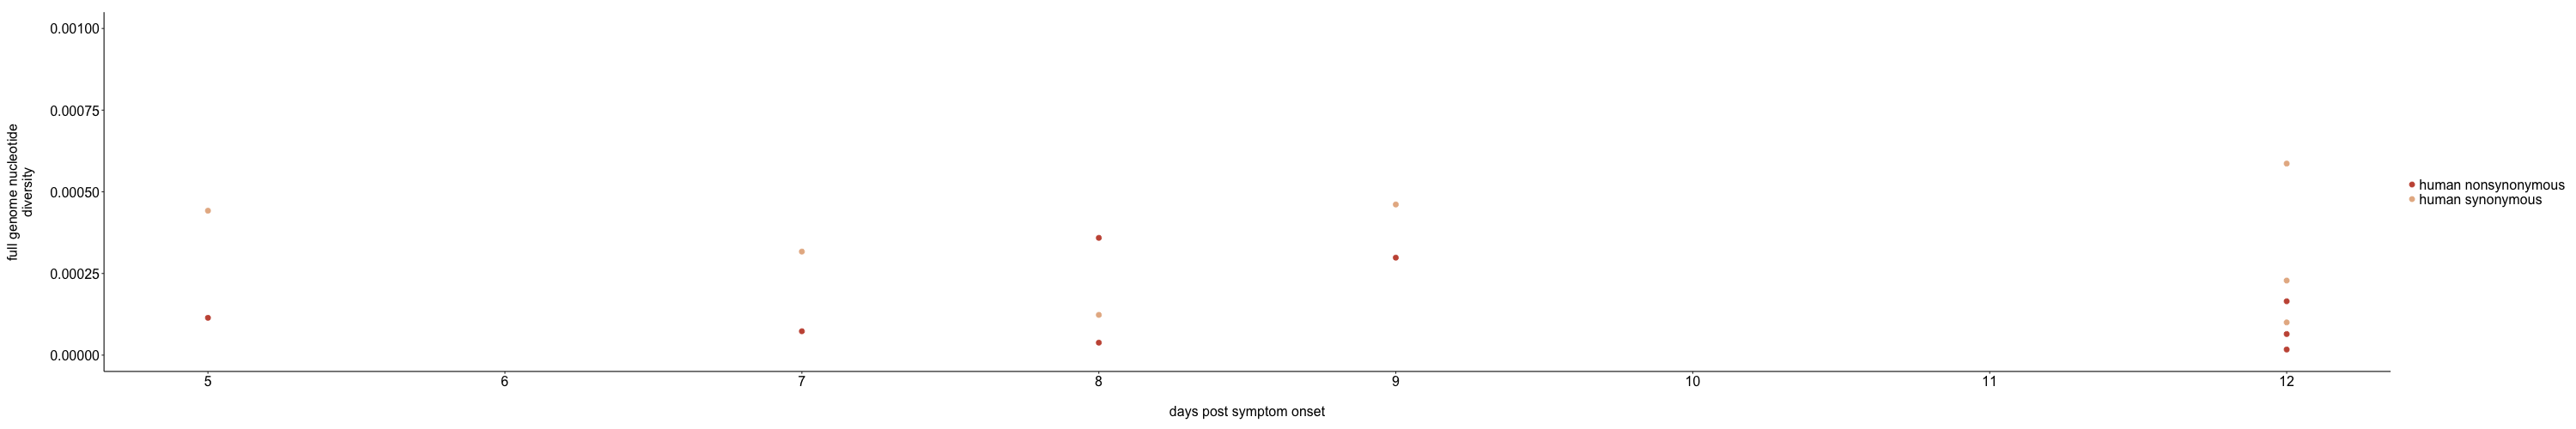

In [77]:
%%R -w 3000 -h 500 -u px -i pi_vs_date_melted,human_nonsyn_color,human_syn_color # this sets the size of the plot...otherwise, it will go off the page"

require(ggplot2)
library(ggplot2)

p <- ggplot(data=pi_vs_date_melted, aes(x=Days_post_symptom_onset, y=value, color=variable))+ #, alpha=host_specific
    geom_point(size=2.5)+
    scale_x_continuous(breaks=seq(5,12,1))+
    scale_y_continuous(limits=c(0,0.001))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    theme(plot.title=element_text(size=16, hjust=0.5))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.5,0.25,0.5,0.25),"cm"))+    # this sets the plot margins as top, left, bottom, right
    theme(axis.line=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=16, vjust=0.5))+
    theme(axis.text=element_text(size=16, colour="black"))+
    scale_color_manual(values=c("piN"=human_nonsyn_color,"piS"=human_syn_color), labels=c("human nonsynonymous","human synonymous"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(panel.background=element_rect(fill=NA, color=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.key.size=unit(0.6, "cm"))+   # alter this to make legend items further apart
    labs(x="\ndays post symptom onset",y="full genome nucleotide\ndiversity\n")+
    theme(legend.direction = 'vertical', legend.position = 'right')

ggsave("Fig-S4-pi-vs-date.pdf", p, width = 8, height = 3.5, useDingbats=FALSE, path="figure-PDFs")
p    

In [78]:
# output correlation between date and diversity
slope, intercept, r_value, p_value, std_err = stats.linregress(pi_vs_date['Days_post_symptom_onset'],pi_vs_date['piN'])
r_value, p_value

(-0.17330946429886587, 0.6814930621205904)

In [79]:
slope, intercept, r_value, p_value, std_err = stats.linregress(pi_vs_date['Days_post_symptom_onset'],pi_vs_date['piS'])
r_value, p_value

(-0.21337157122436423, 0.6119052779005449)

## Perform bootstrapping analysis on diversity values

I had initially plotted mean diversity estimates per gene with error bars representing the standard deviation. This made sense to me, because I thought it would be useful to represent how much variability there was among samples (a lot). However, because variation was so significant among samples, one of our reviewers rightly noted that our error bars crossed 0 into negative diversity values, which doesn't make sense. To remedy this and make the visualization clearer, we settled on bootstrapping our results instead. This bootstrap is implemented as follows: 

1. For each gene and host species, resample πN or πS values, with replacement. For humans, resample 8 (since there are 8 human samples). For ducks, resample 5. 

2. Using this resampled dataset, calculate the mean πN or πS value. 

3. Repeat this process 10,000 times, separately for πN and πS, generating a dataset for each of 10,000 resampled datasets. 

4. Calculate the 2.5% and 97.5% quantile for this set of resampled datasets means. These will become our error bars. 

5. Repeat for each host and gene. 

In [80]:
def fill_in_missing_values(pi_values,sampling_value):
    missing_values = sampling_value - len(pi_values)
    
    for i in range(missing_values):
        pi_values.append(0.0)
    return(pi_values)

In [81]:
def bootrap_pi_values(pi_values, iterations, sampling_value):
    bootstrapped_means = []
    
    for i in range(iterations):
        sample = np.random.choice(pi_values, sampling_value, replace=True)
        mean = np.asarray(sample).mean()
        bootstrapped_means.append(mean)
    
    bootstrapped_means_array = np.array(bootstrapped_means)
    a = np.quantile(bootstrapped_means_array, 0.975)
    b = np.quantile(bootstrapped_means_array, 0.025)
    c = np.std(bootstrapped_means_array)
    
    return(a,b,c)

In [82]:
df = df.append(full_genomes_df)
df.head()

,N_diffs,N_diffs_vs_ref,N_sites,S_diffs,S_diffs_vs_ref,S_sites,Sample ID,file,mean_N_gdiv,mean_S_gdiv,mean_dN_vs_ref,mean_dS_vs_ref,mean_gdiv_polymorphic,piN,piS,product,species
0,1.76712,0.873365,1332.74,0.223554,0.116171,370.651,NaN,AA4KNL706F512_A_Cambodia_X0128304_2013,0.251180976713173,0.0741942362049676,0.000655315,0.000313423,0.198084954560712,0.001326,0.000603,HA,human
1,0.350853,0.185506,578.516,0.208944,0.110311,177.484,NaN,AA4KNL706F512_A_Cambodia_X0128304_2013,0.0872814044904492,0.104176588633549,0.000320659,0.000621526,0.0929131325381493,0.000606,0.001177,M1,human
2,0.0955167,0.0501393,227,0,0,64,NaN,AA4KNL706F512_A_Cambodia_X0128304_2013,0.095250657583352,*,0.000220878,0,0.095250657583352,0.000421,0.000000,M2,human
3,0.137856,0.0715497,1050.12,0.215735,0.115099,296.881,NaN,AA4KNL706F512_A_Cambodia_X0128304_2013,0.0687268855488714,0.107531616100349,6.81348e-05,0.000387694,0.08812925082461,0.000131,0.000727,neuram,human
4,0.0581537,0.0298913,286.01,0,0,76.99,NaN,AA4KNL706F512_A_Cambodia_X0128304_2013,0.0579956285444234,*,0.000104511,0,0.0579956285444234,0.000203,0.000000,NEP,human


In [83]:
iterations = 10000
sampling_values = {"human":8, "duck":5}
df1 = pd.DataFrame()

for species in set(df['species'].tolist()):
    
    for gene in set(df['product'].tolist()):
        for p in ["piN","piS"]:
            
            # add in exception for PB1, since we are missing 1 PB1 sequence 
            if gene == "PB1" and species == "human":
                sampling_value = 7
            else: 
                sampling_value = sampling_values[species]
            
            d = df[(df['product'] == gene) & (df['species'] == species)]
            values = d[p].tolist()
            
            pi_values = fill_in_missing_values(values,sampling_value)
            mean = np.asarray(pi_values).mean()
            a,b,c = bootrap_pi_values(pi_values, iterations, sampling_value)
            
            # generate dataframe 
            x = pd.DataFrame({"species":[species],"gene":[gene],"variable":[p],"mean":[mean],
                            "bootstrap_lower":[b],"bootstrap_upper":[a],"se_mean":[c]})
            df1 = df1.append(x)

In [84]:
df1.head()

,species,gene,variable,mean,bootstrap_lower,bootstrap_upper,se_mean
0,duck,M1,piN,0.000068,0.000000,0.000144,0.000038
0,duck,M1,piS,0.000000,0.000000,0.000000,0.000000
0,duck,PA,piN,0.000037,0.000000,0.000110,0.000033
0,duck,PA,piS,0.000160,0.000028,0.000292,0.000068
0,duck,NS1,piN,0.000036,0.000000,0.000108,0.000032


In [85]:
df1['color'] = df1['species'] + " " + df1['variable'].str.replace("piN","nonsynonymous").replace("piS","synonymous")
df1

,species,gene,variable,mean,bootstrap_lower,bootstrap_upper,se_mean,color
0,duck,M1,piN,0.000068,0.000000,0.000144,0.000038,duck nonsynonymous
0,duck,M1,piS,0.000000,0.000000,0.000000,0.000000,duck synonymous
0,duck,PA,piN,0.000037,0.000000,0.000110,0.000033,duck nonsynonymous
0,duck,PA,piS,0.000160,0.000028,0.000292,0.000068,duck synonymous
0,duck,NS1,piN,0.000036,0.000000,0.000108,0.000032,duck nonsynonymous
0,duck,NS1,piS,0.000000,0.000000,0.000000,0.000000,duck synonymous
0,duck,PB1,piN,0.000009,0.000000,0.000028,0.000008,duck nonsynonymous
0,duck,PB1,piS,0.000066,0.000000,0.000157,0.000040,duck synonymous
0,duck,HA,piN,0.000054,0.000010,0.000098,0.000023,duck nonsynonymous
0,duck,HA,piS,0.000248,0.000000,0.000682,0.000188,duck synonymous


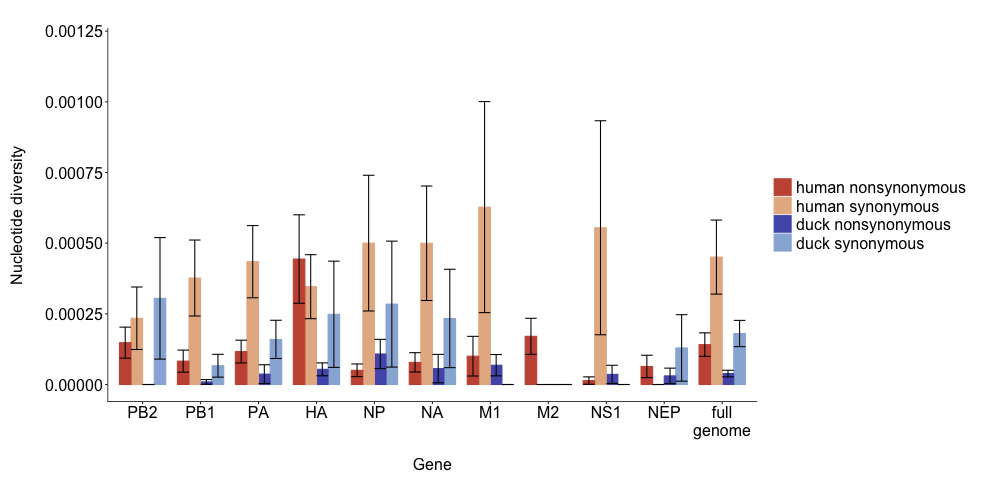

In [86]:
%%R -w 1000 -h 500 -u px -i  df1,human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)

# this block of code is to ensure that even genes without SNPs get plotted so that the bars are all the same size
species_list = unique(df1$species)
gene_list = unique(df1$gene)
variables_list = unique(df1$variable)

for (species in species_list)
{
    for (gene in gene_list)
    {
        for (variable in variables_list)
        {
            x = df1[df1$species == species & df1$gene == gene & df1$variable == variable,]
            if (nrow(x) == 0){
                mean = 0
                std = 0
                if (variable == "N_per_site"){
                    color = paste(species, "nonsynonymous")
                } else{
                    color = paste(species, "synonymous")
                }
                row_to_append = data.frame(gene, species, variable, mean, std, color)
                d = rbind(df, row_to_append)
            }
        }
    }
}

df1$gene = gsub("neuram","NA", df1$gene)
df1$colorf = factor(df1$color, levels=c("human nonsynonymous","human synonymous","duck nonsynonymous","duck synonymous"))
df1$genef = factor(df1$gene, levels=c('PB2','PB1','PA','HA','NP','NA','M1','M2','NS1','NEP','full\ngenome'))

p <- ggplot(data=df1, aes(x=genef, y=mean, color=colorf, fill=colorf, width=0.8)) +
    geom_col(position="dodge")+   
    #geom_errorbar(data=df1, aes(x=genef, ymin=bootstrap_lower, ymax=bootstrap_upper), position="dodge", color="black")+
    geom_errorbar(data=df1, aes(x=genef, ymin=mean-se_mean, ymax=mean+se_mean), position="dodge", color="black")+
    labs(x="\nGene",y="Nucleotide diversity")+
    scale_color_manual(values=c(human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color),breaks = c("human nonsynonymous","human synonymous","duck nonsynonymous","duck synonymous"),labels = c(" human nonsynonymous"," human synonymous"," duck nonsynonymous"," duck synonymous"))+
    scale_fill_manual(values=c(human_nonsyn_color,human_syn_color,duck_nonsyn_color,duck_syn_color),breaks = c("human nonsynonymous","human synonymous","duck nonsynonymous","duck synonymous"),labels = c(" human nonsynonymous"," human synonymous"," duck nonsynonymous"," duck synonymous"))+
    #ggtitle("random tables simulation") + 
    theme(plot.title = element_text(size=20, hjust=0.5))+
    #facet_wrap(~genef, scales="free")+
    scale_y_continuous(limits=c(0,0.0012))+
    theme(strip.text = element_text(size=16))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.65, "cm"))+
    #theme(legend.key=element_rect(fill=NA,size = 2))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("Fig-3-piN-piS-se-mean.pdf", p, width = 14, height = 6, path="figure-PDFs")
p

## Compare piN and piS values with t-test

For each gene and species, compare the set of πN and πS values to each other, to test the null hypothesis that they will be equal (as predicted under neutrality). Do this using a paired t-test. This forms the basis for **Table 2** in the manuscript text. 

In [87]:
df2 = pd.DataFrame()
sampling_values = {"human":8, "duck":5}

for species in set(df['species'].tolist()):
    
    for gene in set(df['product'].tolist()):
        d = df[(df['product'] == gene) & (df['species'] == species)]

        # add in exception for PB1, since we are missing 1 PB1 sequence 
        if gene == "PB1" and species == "human":
            sampling_value = 7
        else: 
            sampling_value = sampling_values[species]
        
        piN_values = list(d['piN'])
        piS_values = list(d['piS'])
        
        diff = sampling_value - len(d)
        for i in range(diff):
            piN_values.append(0.0)
            piS_values.append(0.0)
            
        ttest = stats.ttest_rel(piN_values, piS_values, axis=0)
        pvalue = ttest[1]

        x = pd.DataFrame({"species":[species],"gene":[gene],"pvalue":[pvalue]})
        df2 = df2.append(x)

In [88]:
df2

,species,gene,pvalue
0,duck,M1,0.181457
0,duck,PA,0.093587
0,duck,NS1,0.373901
0,duck,PB1,0.309139
0,duck,HA,0.396980
0,duck,NEP,0.373901
0,duck,NP,0.491429
0,duck,neuram,0.267896
0,duck,full\ngenome,0.037678
0,duck,M2,NaN
